# SDE Parameter Estimation in Python

##Sampling diffusions and diffusion bridges

This notebook discusses two topics: sampling diffusion processes and estimating their parameters from a sequence of observations.

A *diffusion process* is a solution of a stochastic differential equation of the form:

$ dX_t = A(X_t,\theta_1) dt + B(X_t,\theta_2)dW_t$

First we execute the diffusion_functions file.

In [1]:
%run diffusion_functions

.....
----------------------------------------------------------------------
Ran 5 tests in 3.811s

OK


Using the sampleDiffusion function we can generate different diffusion processes.

*Brownian Motion* is an example of diffusion process with zero drift and identity diffusion matrix.

It is a special case of the class of processes with constant drift (here the constant is zero). So we define the following a bit more general drift function:

In [2]:
def drift(x, param):
        return(np.ones(x.shape)*param)   

The diffusion function returns the identity matrix.

In [3]:
def diffusion(x):
    D = np.eye(x.shape[0])
    return(D)

Now we can generate some Brownian Motion paths: 

In [4]:
x = sampleDiffusion(np.zeros(100,),drift,[0],diffusion,[],0.1,10)

In [5]:
%matplotlib inline

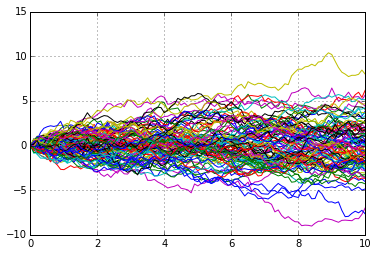

In [6]:
x.plot(legend = False)

Let's introduce a fixed drift.

In [7]:
x = sampleDiffusion(np.zeros(100,),drift,[5],diffusion,[],0.1,10)

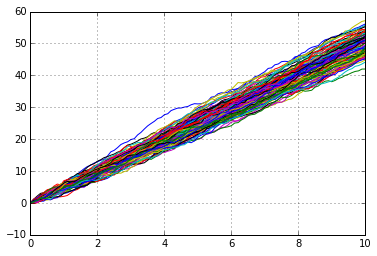

In [8]:
x.plot(legend = False)

Another famous process is the Ornstein-Uhlenbeck process.

$dX_t = \theta(X_t - \mu) dt + dW_t$

In [9]:
def OU_drift(x,theta):
    mu = 5
    return(theta*(mu - np.array(x)))

In [10]:
x = sampleDiffusion(np.zeros(100,),OU_drift,[0.5],diffusion,[],0.1,10)

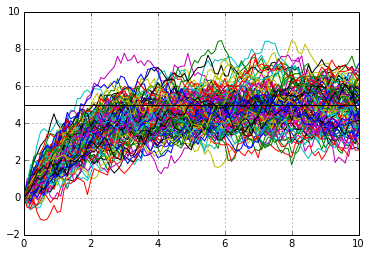

In [11]:
x.plot(legend = False)
plt.axhline(5,color = 'k')

After some time the process begins to oscillate around its mean, as it is a stationary Gaussian process.

We also introduce the diffusion bridge processes. These are diffusions whose starting and ending points are pinned, or more precisely, they are conditioned on the final state of the process. 

The *Browinian Bridge* satisfies $dX_t = dW_t$ s.t. $X_1 = 0$. Luckily, this process has explicit distribution 
$X_t = W_t - t$

In [12]:
x = sampleDiffusion(np.zeros(100,),drift,[0],diffusion,[],0.01,1)
#bb = x - np.tile(np.reshape(np.array(x.index), (101,1)),100)* 
index = np.array(x.index)
bb = x - np.reshape(index, (len(index),1))* np.reshape(x.loc[1],(1,len(x.loc[1])))

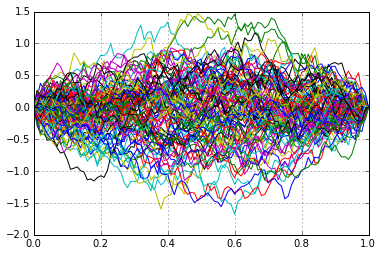

In [13]:
bb.plot(legend = False)

An alternative way of looking into bridges is as diffusion processes (Be correct mathematically here!)

Suppose we have an explicit formula for the transition density of the process $X_t$. 

$$p_{t,s}(x,y) = P(X_s = y|X_t = x)$$

Then the diffusion bridge process can be written as 

$$dX_t = -\nabla_y \log p(x,y) dt + dW_t$$ 
(I can write a more general version with mixing matrix)

With a little work one can obtain that a Brownian Bridge process pinned to value $y$ at time $T$  is

$$dX_t = - \frac{y - X_t}{T - t} dt + dW_t$$

To simulate it we can use the general diffusion sampling function.

In [14]:
def drift(x,t,y):
    return((y - x)/(1 - t))

In [15]:
x = sampleDiffusion_timedependent(np.zeros(100,),drift,[0],diffusion,[],0.01,1)

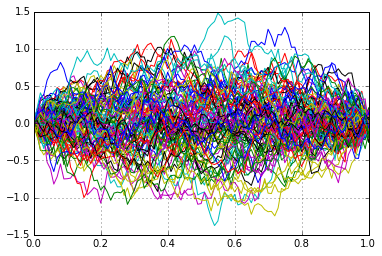

In [16]:
x.plot(legend = False)

(The last point does not get pinned - because of the noise - I can force it)

The beginning and starting points do not need to be the same.

In [17]:
x = sampleDiffusion_timedependent(np.zeros(100,),drift,[5],diffusion,[],0.01,1)

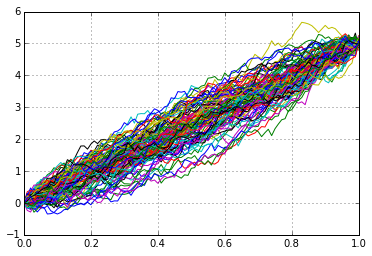

In [18]:
x.plot(legend = False)

Diffusion bridge for Ornstein Uhlenbeck process.

Diffusion bridge with a constant drift?

Diffusion bridge with a general drift?

## Importance Sampling

When it is hard to sample from a given probabilistic law, one can often generate a sample from a proposal distribution and then reweight this sample to obtain a sample from the desired distribution. This is known as *Importance Sampling*. As it is often hard to sample from diffusion bridges directly, one can often use importance sampling to obtain samples (other MCMC approaches are useful). 

We summarize the procedure as follows:
* $p(x)$ - density of the target distribution
* $q(x)$ - density of the proposal distribution


1. sample from 
2. attach a weight to each sample point p(x)/q(x) and normalize
3. resample according to the weights and set weights 1/N

How to display that one path will appear many times?

Simple example:

Sample from the proposal distribution $X\sim \mathcal{N}(0,1)$.

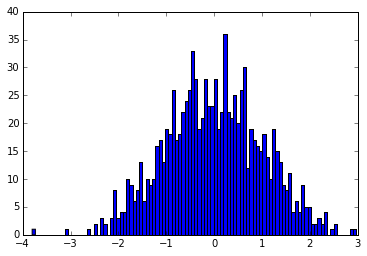

In [19]:
x = np.random.normal(np.zeros(1000,),np.ones(1000,))
_ = plt.hist(x,bins = 100)

Target distribution $X\sim \mathcal{N}(\mu,1)$.

Ratio of pdfs: $e^{-(mu-x)^2/2}$ $/e^{-x^2/2} = e^{\mu x-\mu^2/2}$

In [20]:
mu = 5
w = sp.exp(mu*x)

# Parameter Estimation

We observe $X_1,...,X_N$ 

Likelihood ratio

$L(X,\theta) = \int A(X_t,\theta)*A(X_t,\theta) dt + \int A(X_t,\theta)dX_t$

$\theta^* = \arg\max L(X_1,...,X_n)$

Generate discrete observations:

In [21]:
def drift(x, param):
    return(np.ones(x.shape)*param)
def diffusion(x):
    D = np.eye(x.shape[0])
    return(D)
x = sampleDiffusion(np.zeros((100,)),drift,[5],diffusion,[],0.1, 10)

We can define the likelihood function.

In [22]:
def define_L(data, drift, diffusion, dt):
    def L(param):
        data_diff = data.diff().iloc[1::]
        ratio = dt * drift(data.iloc[1::],param)*drift(data.iloc[1::],param)/2 - drift(data.iloc[1::],param)*np.array(data_diff)
        return(sum(sum(ratio)))
    return L

In [23]:
L = define_L(x,drift,diffusion,0.1)
theta_hat = minimize(L,0,method = 'Nelder-Mead').x
theta_hat[0]

4.9764375000000065

In general, we are interested how this parameter estimate changes when we have more observations. 

In [24]:
theta_hat = []
for dt in [1,0.1,0.01]:
    data = sampleDiffusion(np.zeros((100,)),drift,[5],diffusion,[],dt,10)
    L = define_L(data,drift,diffusion,dt)
    theta_hat.append(minimize(L,0,method = 'Nelder-Mead').x[0])

theta_hat

[4.9697500000000057, 5.0460625000000068, 5.0158750000000056]

At a simple glance it does not seem the estimates are improving much. If we think a bit deeper we realize that when we have constant drift and diffusion, the estimate simly depends on the first and final observation: so it does not matter how many observations we obtain inbetween!